In [22]:
import sys

sys.path.append('../../')

import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from keras.layers import Dense, Conv1D, MaxPool1D, Lambda, Add
from keras import Input, Model, Sequential

from Pipeline.tf_dataset_builder import DatasetBuilderRaw
from Pipeline.evaluation import plot_confusion_matrix, detection_report
from Pipeline.tf_lite_utils import convert_tf_lite_mtl, predict_tflite_mtl, convert_tf_lite

In [2]:
# Set seed for experiment reproducibility
seed = 1
tf.random.set_seed(seed)

In [3]:
# Define paths to model files
MODELS_DIR = '../../Models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'mtl_model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'mtl_model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'mtl_model.tflite'

In [4]:
class_dict = {
    'Background': 0,
    'Big mandibles': 1,
    'Small mandibles': 2,
}

In [5]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
patience = 10
gamma = 0.5

In [6]:
# Load the data: raw extraction
DatasetBuilder = DatasetBuilderRaw(
    dataset_dir="../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav",
    batch_size=batch_size,
    class_dict=class_dict,
    augment=False,
    balanced=False,
    multi_task=True,
    normalize=True,
    seed=seed,
    sample_rate=44100
)
train_dataset, val_dataset, test_dataset = DatasetBuilder.build(val_split=0.2, test_split=0.2)

In [7]:
input_shape = test_dataset[0][0].shape
input_shape

(2205, 1)

In [8]:
# First the input layer
input_ = Input(shape=input_shape, name = 'input')

# First convolution layer
conv_1 = Conv1D(filters=32, kernel_size=80, padding="same", activation='relu', name = 'conv_1')(input_)

# Maxpool layer
pool_1 = MaxPool1D(pool_size=4, strides=2, name = 'pool_1')(conv_1)
# Flatten layer
flat_1 = Lambda(lambda x: K.mean(x, axis=1))(pool_1)

# First Output Layer
output_1 =  Dense(1, activation = 'sigmoid', name = 'detection')(flat_1)

# Second convolution layer
conv_2 = Conv1D(filters=32, kernel_size=3, padding="same", activation='relu', name = 'conv_2')(conv_1)

# Third convolution layer
conv_3 = Conv1D(filters=32, kernel_size=3, padding="same", activation='relu', name = 'conv_3')(conv_2)

# Add Layer :
# connect the first convolution layer's output with the output of the thired convolution layer and add both.
add = Add(name = 'add')([conv_1, conv_3])

# maxpool layer
pool_2 = MaxPool1D(4, name = 'pool_2')(add)
# flatten layer
flat_2 = Lambda(lambda x: K.mean(x, axis=1))(pool_2)

# Our Secound Output layers
output_2 = Dense(len(class_dict), activation = 'softmax', name = 'classification')(flat_2)

# Create the model
multitask_model = Model(input_, [output_1, output_2])

In [9]:
multitask_model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 2205, 1)]    0           []                               
                                                                                                  
 conv_1 (Conv1D)                (None, 2205, 32)     2592        ['input[0][0]']                  
                                                                                                  
 conv_2 (Conv1D)                (None, 2205, 32)     3104        ['conv_1[0][0]']                 
                                                                                                  
 conv_3 (Conv1D)                (None, 2205, 32)     3104        ['conv_2[0][0]']                 
                                                                                              

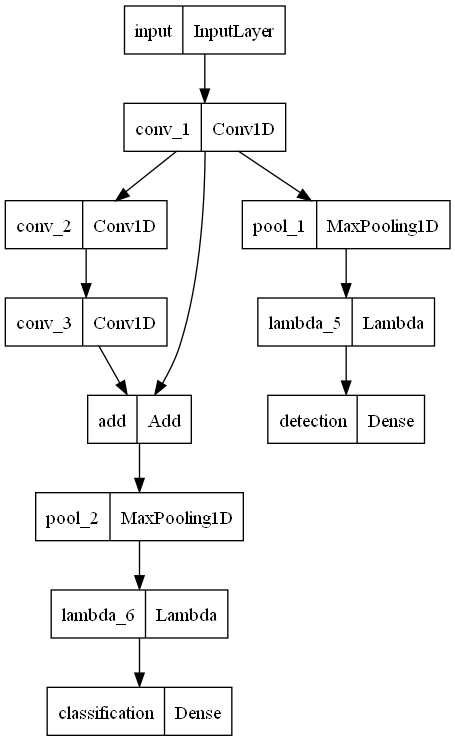

In [31]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
tf.keras.utils.plot_model(multitask_model, expand_nested=True)

In [10]:
loss1 = tf.keras.losses.BinaryCrossentropy()
loss2 = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

losses = {
    'detection': loss1,
    'classification': loss2
}

loss_weights = {
    'detection': gamma,
    'classification': 1 - gamma
}

metrics = ['accuracy']

multitask_model.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics,
)

In [11]:
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(verbose=1, patience=patience)

history = multitask_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100
35/35 [==============================] - 5s 117ms/step - loss: 0.8347 - detection_loss: 0.6407 - classification_loss: 1.0286 - detection_accuracy: 0.6701 - classification_accuracy: 0.4598 - val_loss: 0.7886 - val_detection_loss: 0.6119 - val_classification_loss: 0.9654 - val_detection_accuracy: 0.7054 - val_classification_accuracy: 0.5393 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 4s 111ms/step - loss: 0.7440 - detection_loss: 0.5875 - classification_loss: 0.9006 - detection_accuracy: 0.7183 - classification_accuracy: 0.5897 - val_loss: 0.7275 - val_detection_loss: 0.5652 - val_classification_loss: 0.8899 - val_detection_accuracy: 0.7464 - val_classification_accuracy: 0.5625 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - 4s 111ms/step - loss: 0.6877 - detection_loss: 0.5493 - classification_loss: 0.8261 - detection_accuracy: 0.7415 - classification_accuracy: 0.6473 - val_loss: 0.6885 - val_detection_loss: 0.5394 - val_classification

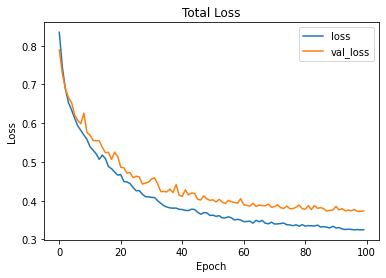

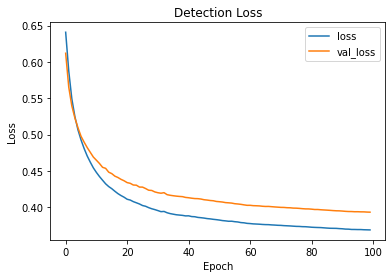

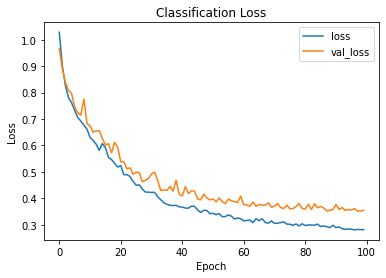

In [12]:
metrics = history.history
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['detection_loss'], metrics['val_detection_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['classification_loss'], metrics['val_classification_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [13]:
test_features = test_dataset[0]
predictions = multitask_model.predict(test_features, verbose=1)

y_pred = np.rint(predictions[0]).astype(int).flatten()
y_true = test_dataset[1]['detection']

detection_report(y_true, y_pred)

22/22 [==============================] - 0s 14ms/step

Evaluation on the test set:
False alarm prob: 21.64%
Miss detection prob: 12.04%
Number of False Positives: 58
Number of False Negatives: 52
Detector f1-score is 87.356322%

Other Metrics:
Detector accuracy is 84.285714%
Detector precision is 86.757991%
Detector recall is 87.962963%


Classification test set accuracy: 84%


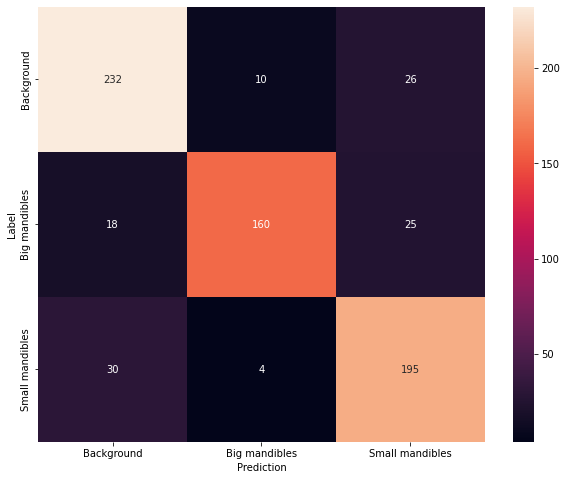

In [14]:
y_pred = np.argmax(predictions[1], axis=1)
y_true = test_dataset[1]['classification']

test_acc = accuracy_score(y_true=y_true, y_pred=y_pred)
print(f'Classification test set accuracy: {test_acc:.0%}')

plot_confusion_matrix(list(class_dict.keys()), y_true, y_pred)

In [23]:
multitask_model.save(MODEL_TF)
convert_tf_lite(MODEL_TF, MODEL_NO_QUANT_TFLITE)

Float model is 42676 bytes


In [26]:
def representative_dataset():
    for feature, label in train_dataset.take(100):
        yield {
            "input": feature.numpy(),
            "detection": label['detection'].numpy(),
            "classification": label['classification'].numpy(),
        }

In [27]:
# Define the input and output details for TensorFlow Lite
input_details = multitask_model.input
output_details = [multitask_model.output[0], multitask_model.output[1]]
# Convert to TensorFlow Lite model
convert_tf_lite_mtl(MODEL_TF, MODEL_TFLITE, representative_dataset, output_details)

Quantized model is 19584 bytes


In [28]:
y_pred_det, y_pred_class = predict_tflite_mtl(MODEL_TFLITE, test_features)

print("Quantized detection report:")
detection_report(test_dataset[1]['detection'], y_pred_det.flatten())

Quantized detection report:

Evaluation on the test set:
False alarm prob: 9.7%
Miss detection prob: 39.35%
Number of False Positives: 26
Number of False Negatives: 170
Detector f1-score is 72.777778%

Other Metrics:
Detector accuracy is 72.000000%
Detector precision is 90.972222%
Detector recall is 60.648148%


              precision    recall  f1-score   support

           0     0.7067    0.9888    0.8243       268
           1     0.8978    0.8227    0.8586       203
           2     0.9784    0.5939    0.7391       229

    accuracy                         0.8114       700
   macro avg     0.8610    0.8018    0.8073       700
weighted avg     0.8510    0.8114    0.8064       700



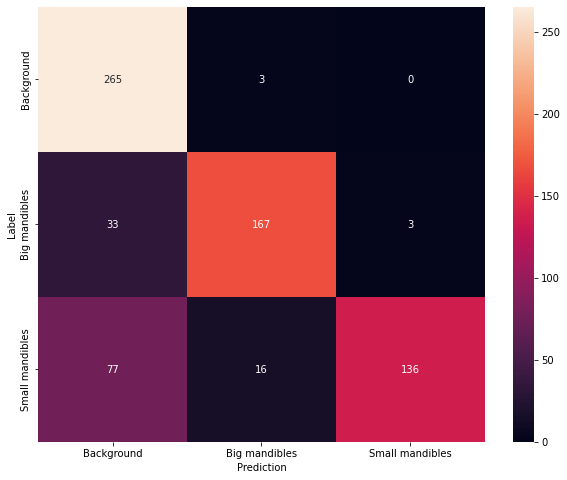

In [29]:
print(classification_report(test_dataset[1]['classification'], y_pred_class, digits=4))
plot_confusion_matrix(list(class_dict.keys()), test_dataset[1]['classification'], y_pred_class)